In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from visualservoing import DataSelector, LocalLeastSquareUVS


In [64]:
results = torch.load('results-12345-broyden.pth')

In [65]:
results.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

# Scatter plot of targets
This section is just to see how distributed our targets are in the robot's space. I think technically (as of writing May 27,2020) the way I generate targets is biased. The only point of this is to see the spread of target generation

In [66]:
train_data = np.load('local_linear_uvs.npy', allow_pickle=True).item()

100000


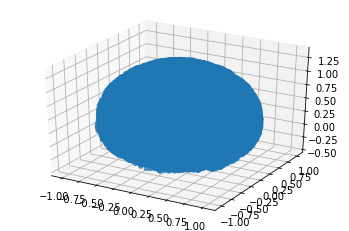

In [67]:
states = train_data['X'] #TODO this will be X in future runs
targets = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#local linear stores angles + position, not targets
for v in states:#results.items():
    target = v
    if np.linalg.norm(target) <= 1.5:
        targets.append(target)
print(len(targets))
targets = np.array(targets).T
ax.scatter(targets[0], targets[1], targets[2])    


# Checking Jacobian Approximations
I have an itching suspicion that the more data you collect, the more likely it is you will have nearest neighbors that either are the point of interest (i.e. you've been there before) or be so infinitely small in terms of change that the right "Jacobian" really is to be 0 because you are not moving, or that there isn't a good fit period.


First, we create our datasets

In [68]:
k = 50
selector = DataSelector(k=k)
uvs = LocalLeastSquareUVS(gain= 1.0, k=k,
                          solve_least_square_together=False)

Q, X = train_data['Q'], train_data['X'] #TODO this will be X in future runs
Q = np.array(Q)
X = np.array(X)
q = np.zeros(7)

(Q,X) = selector.select_data(q,Q, X)
print(Q.shape)

dQ, dX = uvs.createFiniteDifferenceDataset(Q, X)
print(dQ.shape)

(50, 7)
(2500, 7)


Next, let's look at what's going on in our least square fit now

In [69]:
#we fit each row of J separately in this case
[n, d] = dQ.shape
[n, t] = dX.shape

J = np.zeros((t, d))
for i in range(t):
    X = dQ
    y = dX[:, i].reshape(-1, 1)
    XtX = np.matmul(X.T, X)
    Xty = np.matmul(X.T, y)

    det = np.linalg.det(XtX)
    if abs(det) < 1e-7 and abs(det) > -1e-7:
        XtX = XtX + np.identity(self.num_actuators)* 1e-10

    w = np.matmul(np.linalg.inv(XtX), Xty)
    for j in range(d):
        J[i, j] = w[j]
J


array([[-0.01870832,  0.97851647, -0.01944235,  0.58277318, -0.00522685,
         0.28726775,  0.0096431 ],
       [-0.03015311,  0.22180393,  0.05096231, -0.0099297 , -0.0226762 ,
        -0.17144499, -0.10197855],
       [ 0.00204676, -0.11779249,  0.02835257, -0.01167879,  0.02929442,
         0.09696245,  0.03891465]])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

Text(0, 0.5, 'mean-squared-error')

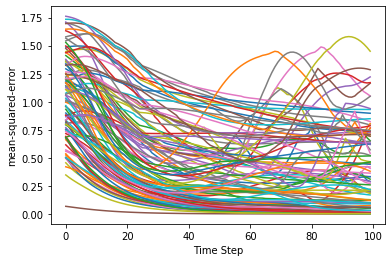

In [70]:
#note that we never use initial state FYI
#Plotting norm of difference
err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        state = v[0]

        psn = state[0:3]
        targ = state[-3:]
        
        mse = np.linalg.norm(targ - psn, 2)
        episode_err.append(mse)
    err_over_time.append(episode_err)

plt.plot(np.array(err_over_time).T)
plt.xlabel("Time Step")
plt.ylabel("mean-squared-error")


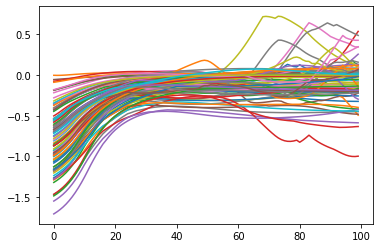

In [77]:
#note that we never use initial state FYI
#Plot Specific Dimension
dim = 2
err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        state = v[0]

        psn = state[dim]
        targ = state[-3 + dim]
        mse = targ - psn
        episode_err.append(mse)
    err_over_time.append(episode_err)

plt.plot(np.array(err_over_time).T)

# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

(100, 100)
728.8193785250122
25.804197267827494


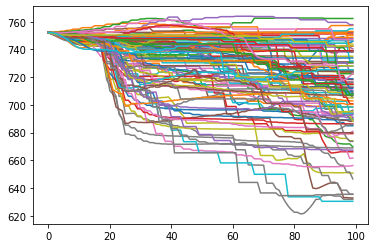

In [72]:


err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        estimate_J = v[-2] 
        #estimate_J = normalize_rows(estimate_J)
        true_J = v[-1]
        #true_J = normalize_rows(true_J)
    
        mse = np.linalg.norm(estimate_J - true_J, 'fro')
        episode_err.append(mse)
    err_over_time.append(episode_err)
print(np.array(err_over_time).shape)
print(np.array(err_over_time).mean())
print(np.array(err_over_time).std())
plt.plot(np.array(err_over_time).T)


Text(0, 0.5, 'Frobenius Norm difference of True vs approximate J')

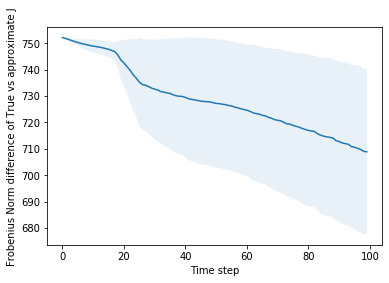

In [78]:
#Just approximating 
err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        estimate_J = v[-2] 
        #estimate_J = normalize_rows(estimate_J)
        
        true_J = v[-1]
        #true_J = normalize_rows(true_J)
    
        mse = np.linalg.norm(estimate_J - true_J, 'fro')
        episode_err.append(mse)
    err_over_time.append(episode_err)

mean = np.array(err_over_time).mean(axis=0)
std = np.array(err_over_time).std(axis=0)
plt.plot(mean)
plt.fill_between(list(range(100)), mean + std, mean - std, alpha=0.1)
plt.xlabel("Time step")
plt.ylabel("Frobenius Norm difference of True vs approximate J")

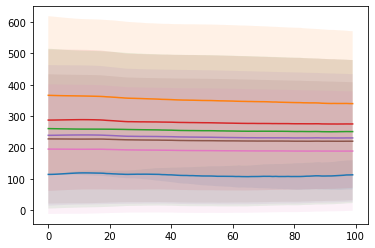

In [79]:
# look at each column 
err_over_time = []
for i in range(7):
    for k, value in results.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2][:,i] 
            #estimate_J = normalize_rows(estimate_J)

            true_J = v[-1][:,i]
            #true_J = normalize_rows(true_J)

            mse = np.linalg.norm(estimate_J - true_J, )
            episode_err.append(mse)
        err_over_time.append(episode_err)

    mean = np.array(err_over_time).mean(axis=0)
    std = np.array(err_over_time).std(axis=0)
    plt.plot(mean)
    plt.fill_between(list(range(100)), mean + std, mean - std, alpha=0.1)
plt.show()

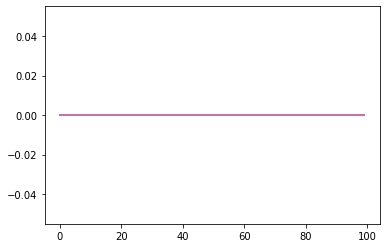

In [82]:
# Look at determinant of inv(J) * J
err_over_time = []
for i in range(7):
    for k, value in results.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 
            #estimate_J = normalize_rows(estimate_J)
            est_Ji = np.linalg.pinv(estimate_J)
            true_J = v[-1]
            
            res = np.matmul(est_Ji, true_J)          
            det = np.linalg.det(res)
            episode_err.append(det)
        err_over_time.append(episode_err)

    mean = np.array(err_over_time).mean(axis=0)
    std = np.array(err_over_time).std(axis=0)
    plt.plot(mean)
    plt.fill_between(list(range(100)), mean + std, mean - std, alpha=0.1)
plt.show()

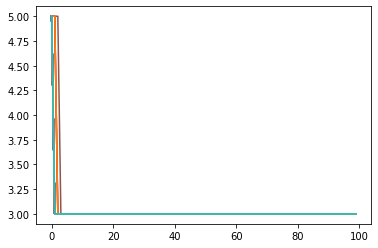

In [83]:

#just consider signs of them
err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        estimate_J = np.sign(v[-2]) 
        
        
        true_J = np.sign(v[-1])
        
        sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
        loss = (sign_mismatch).sum()
        episode_err.append(loss)
    err_over_time.append(episode_err)
    
plt.plot(np.array(err_over_time).T)

# Checking Our Jacobians
In this section we look at our Jacobians to determine if they are well 
conditioned to achieve convergence


In [63]:
err_over_time = []
for k, value in results.items():
    episode_err = []
    for v in value:
        estimate_J = v[-2] 
        #estimate_J = normalize_rows(estimate_J)
        JTJ = np.matmul(estimate_J.T, estimate_J)
        singular_vals = np.linalg.eigvals(JTJ)
        
        real_eig = np.real(eigvals)
        print((np.abs(real_eig) < 0).all())
        
        

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals